In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./stock_historical_data/{}.csv".format("LT.NS"))
df.set_index("Date", inplace=True)
df["date"] = df.index

In [65]:
new_df = pd.DataFrame(df.Close)
new_df.reset_index(inplace=True)

In [67]:
new_df = new_df.drop("Date",axis=1)

,Close
0,1226.583862
1,1259.684326
2,1250.086548
3,1232.951172
4,1236.462646
...,...
885,2560.899902
886,2646.250000
887,2660.199951
888,2649.550049


In [68]:
#scaling fream
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [69]:
##splitting dataset into train and test split
training_size = int(len(new_df)*0.8)
test_size     = len(new_df) - training_size
train_data,test_data = new_df[0:training_size,:],new_df[training_size:len(new_df),:1]

In [106]:
new_df.shape,train_data.shape,test_data.shape

((890, 1), (712, 1), (178, 1))

In [70]:
train_data.shape , test_data.shape

((712, 1), (178, 1))

In [71]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[(i+time_step)+1][0])

    return numpy.array(dataX), numpy.array(dataY)

In [86]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest    = create_dataset(test_data, time_step)

In [87]:
X_train.shape,y_train.shape,X_test.shape,ytest.shape

((611, 100), (611,), (77, 100), (77,))

In [88]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [89]:
X_test.shape

(77, 100, 1)

In [90]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [91]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=2,batch_size=64,verbose=1)

Epoch 1/2
10/10 [==============================] - 9s 298ms/step - loss: 0.0473 - val_loss: 0.0458
Epoch 2/2
10/10 [==============================] - 2s 155ms/step - loss: 0.0092 - val_loss: 0.0100


In [94]:
import tensorflow as tf

In [95]:
### Lets Do the prediction and check performance metrics
train_predict =  model.predict(X_train)
test_predict  =  model.predict(X_test)

3/3 [==============================] - 0s 42ms/step


In [96]:
##Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)

In [120]:
test_predict

array([[2105.519 ],
       [2107.3484],
       [2109.9988],
       [2113.3213],
       [2117.0164],
       [2120.6663],
       [2124.0535],
       [2127.068 ],
       [2129.7205],
       [2131.9417],
       [2133.7903],
       [2135.4006],
       [2136.9807],
       [2138.76  ],
       [2141.095 ],
       [2144.179 ],
       [2147.8909],
       [2152.0984],
       [2156.7493],
       [2161.6746],
       [2166.7686],
       [2171.8704],
       [2176.2961],
       [2179.6694],
       [2181.9817],
       [2183.2014],
       [2183.377 ],
       [2182.4863],
       [2180.6448],
       [2178.136 ],
       [2175.0913],
       [2171.6072],
       [2167.8965],
       [2164.1775],
       [2160.6182],
       [2157.2556],
       [2154.0996],
       [2151.1702],
       [2148.6018],
       [2146.5964],
       [2145.256 ],
       [2144.7578],
       [2145.2222],
       [2146.7178],
       [2149.061 ],
       [2152.1362],
       [2155.7852],
       [2159.8716],
       [2164.2725],
       [2168.8542],


In [117]:
train_predict.shape,test_predict.shape
result = np.concatenate((train_predict, test_predict), axis=0)
result.shape,train_predict.shape

((688, 1), (611, 1))

In [97]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1610.970422069533

In [98]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

2178.715635093586

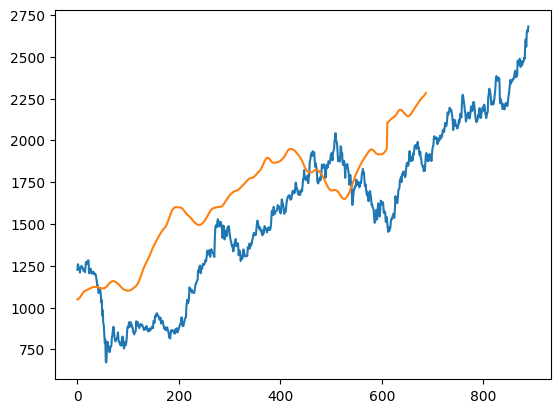

In [119]:
### Plotting 
# shift train predictions for plotting
look_back=100
#trainPredictPlot = numpy.empty_like(df1)
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
#testPredictPlot = numpy.empty_like(df1)
#testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(new_df))
plt.plot(result)
#plt.plot(train_predict)
plt.show()

In [110]:
new_df.shape,trainPredictPlot.shape,testPredictPlot.shape

((890, 1), (890, 1), (890, 1))